## Library

In [1]:
import platform
import os
import random

from sklearn.metrics import f1_score, classification_report
import efficientnet
import efficientnet.tfkeras as efn
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt


In [2]:
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
print('Python version:', platform.python_version())
print('Tensorflow Version:', tf.__version__)
print('Tensorflow Addons Version:', tfa.__version__)
print('Efficientnet Version:', efficientnet.__version__)
print('Numpy Version:', np.__version__)
print('Matplotlib Version:', matplotlib.__version__)


Python version: 3.8.3
Tensorflow Version: 2.2.0
Tensorflow Addons Version: 0.10.0
Efficientnet Version: 1.1.0
Numpy Version: 1.18.5
Matplotlib Version: 3.2.1


## Dataset

In [4]:
def fft(image):
    fourier = []

    for i in range(image.shape[2]):
        img = image[:, :, i]
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        fourier.append(magnitude_spectrum)

    fourier = (np.dstack(fourier)).astype(np.uint8)

    return fourier


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [6]:
len_x_train = len(x_train)
len_x_test = len(x_test)

for i in range(len_x_train):
    x_train[i] = fft(x_train[i])
for i in range(len_x_test):
    x_test[i] = fft(x_test[i])


## Check fourier transform image

In [7]:
def show_fft(image):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title('Fourier Transform image')
    plt.xticks([]), plt.yticks([])
    plt.show()


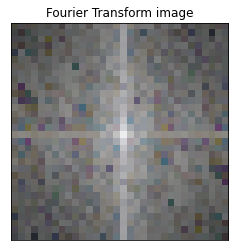

In [8]:
show_fft(x_train[np.random.randint(0, len_x_train)])


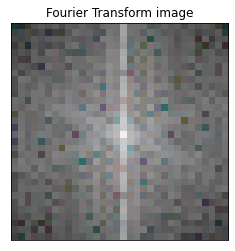

In [9]:
show_fft(x_train[np.random.randint(0, len_x_train)])


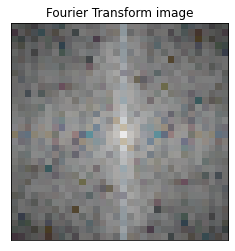

In [10]:
show_fft(x_train[np.random.randint(0, len_x_train)])


## Configure model

In [11]:
efn0 = efn.EfficientNetB0(
    input_shape=(32, 32, 3), include_top=False,
    weights='noisy-student', pooling='max',
)
model = tf.keras.Sequential([
    efn0,
    Dense(10, activation='softmax')
])
model.compile(
    optimizer=tfa.optimizers.RectifiedAdam(
        lr=0.005,
        total_steps=50,
        warmup_proportion=0.1,
        min_lr=0.0005,
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,062,374
Trainable params: 4,020,358
Non-trainable params: 42,016
_________________________________________________________________


## Train model

In [12]:
model.fit(
    x_train, y_train,
    batch_size=500, epochs=50, verbose=1
)


Epoch 1/50
100/100 [==============================] - 19s 186ms/step - loss: 2.3092 - sparse_categorical_accuracy: 0.1755
Epoch 2/50
100/100 [==============================] - 19s 187ms/step - loss: 2.0628 - sparse_categorical_accuracy: 0.2553
Epoch 3/50
100/100 [==============================] - 18s 185ms/step - loss: 1.9063 - sparse_categorical_accuracy: 0.3144
Epoch 4/50
100/100 [==============================] - 18s 185ms/step - loss: 1.7755 - sparse_categorical_accuracy: 0.3633
Epoch 5/50
100/100 [==============================] - 19s 187ms/step - loss: 1.6594 - sparse_categorical_accuracy: 0.4042
Epoch 6/50
100/100 [==============================] - 19s 187ms/step - loss: 1.5610 - sparse_categorical_accuracy: 0.4418
Epoch 7/50
100/100 [==============================] - 19s 186ms/step - loss: 1.4683 - sparse_categorical_accuracy: 0.4760
Epoch 8/50
100/100 [==============================] - 19s 187ms/step - loss: 1.3727 - sparse_categorical_accuracy: 0.5104
Epoch 9/50
100/100 [====

## Test model

In [13]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)


In [14]:
f1 = f1_score(y_test, y_pred, average='weighted')

print('Weighted F1 Score:', f1)


Weighted F1 Score: 0.3786648010406338


In [15]:
print('Classification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.41      0.42      1000
           1       0.39      0.35      0.37      1000
           2       0.37      0.28      0.32      1000
           3       0.24      0.25      0.25      1000
           4       0.39      0.37      0.38      1000
           5       0.35      0.38      0.36      1000
           6       0.47      0.54      0.50      1000
           7       0.28      0.34      0.31      1000
           8       0.49      0.36      0.42      1000
           9       0.43      0.50      0.46      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.38     10000
weighted avg       0.38      0.38      0.38     10000

